#Importing Dependencies

In [26]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch.nn import CrossEntropyLoss
from sklearn.metrics import classification_report,accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download ankurzing/sentiment-analysis-for-financial-news

Dataset URL: https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news
License(s): CC-BY-NC-SA-4.0
  0% 0.00/903k [00:00<?, ?B/s]
100% 903k/903k [00:00<00:00, 1.23GB/s]


In [4]:
!unzip sentiment-analysis-for-financial-news.zip

Archive:  sentiment-analysis-for-financial-news.zip
  inflating: FinancialPhraseBank/License.txt  
  inflating: FinancialPhraseBank/README.txt  
  inflating: FinancialPhraseBank/Sentences_50Agree.txt  
  inflating: FinancialPhraseBank/Sentences_66Agree.txt  
  inflating: FinancialPhraseBank/Sentences_75Agree.txt  
  inflating: FinancialPhraseBank/Sentences_AllAgree.txt  
  inflating: all-data.csv            


#Handling Data

In [5]:
df = pd.read_csv("all-data.csv", names=["sentiment", "text"], encoding="ISO-8859-1")

# Encode labels (0 = negative, 1 = neutral, 2 = positive)
df['label'] = df['sentiment'].astype('category').cat.codes

In [6]:
df.isna().sum()

,0
sentiment,0
text,0
label,0


In [7]:
train_val_df, test_df = train_test_split(
    df,
    test_size=0.1,  # 10% test
    stratify=df['label'],
    random_state=42
)

# Then split train+val into train and val
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.1,  # 10% of remaining for validation
    stratify=train_val_df['label'],
    random_state=42
)

#Model And Tokenizer

In [8]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [9]:
def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=128)


In [10]:
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/3924 [00:00<?, ? examples/s]

Map:   0%|          | 0/437 [00:00<?, ? examples/s]

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

#Handling Class Imbalance

In [11]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class Weights:", class_weights)

Class Weights: tensor([2.6748, 0.5611, 1.1848])


In [19]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

#Training

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(df['label'].unique()))


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50
)

In [20]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

/tmp/ipython-input-1084593971.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


In [21]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.524300,0.390057
2,0.301300,0.376297
3,0.173700,0.360763


TrainOutput(global_step=738, training_loss=0.3717939052478408, metrics={'train_runtime': 323.6871, 'train_samples_per_second': 36.368, 'train_steps_per_second': 2.28, 'total_flos': 774342788373504.0, 'train_loss': 0.3717939052478408, 'epoch': 3.0})

In [32]:
torch.save(model, "BERT_Sentiment.pth")

In [34]:
tokenizer.save_pretrained('saved_tokenizer')

('saved_tokenizer/tokenizer_config.json',
 'saved_tokenizer/special_tokens_map.json',
 'saved_tokenizer/vocab.txt',
 'saved_tokenizer/added_tokens.json',
 'saved_tokenizer/tokenizer.json')

In [36]:
trainer.save_state()
trainer.save_model("saved_model")

In [37]:
import shutil

model_dir = "/content/saved_model"
shutil.make_archive("model", 'zip', model_dir)

'/content/model.zip'

#Evaluation

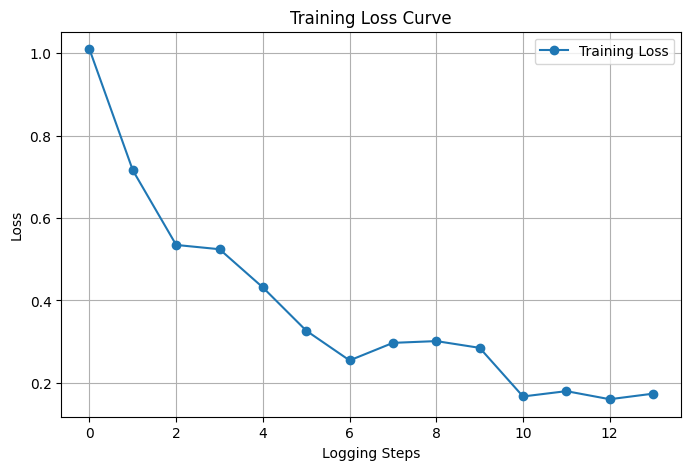

In [29]:
losses = [log["loss"] for log in trainer.state.log_history if "loss" in log]

# Plot loss curve
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Training Loss", marker='o')
plt.xlabel("Logging Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

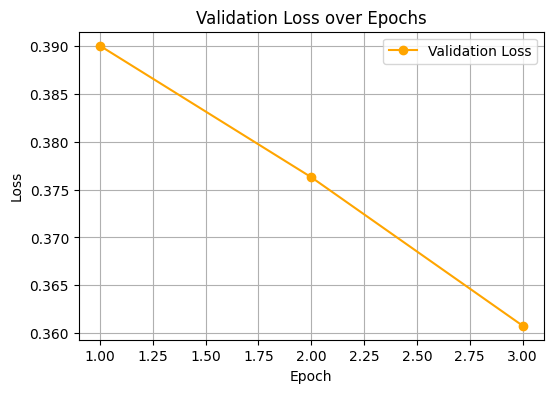

In [31]:
val_losses = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
epochs = range(1, len(val_losses) + 1)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(epochs, val_losses, marker='o', label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.grid(True)
plt.legend()
plt.show()

In [25]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'  # weighted handles class imbalance
    )

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

              precision    recall  f1-score   support

           0       0.75      0.87      0.80        61
           1       0.90      0.83      0.86       288
           2       0.72      0.80      0.76       136

    accuracy                           0.82       485
   macro avg       0.79      0.83      0.81       485
weighted avg       0.83      0.82      0.83       485



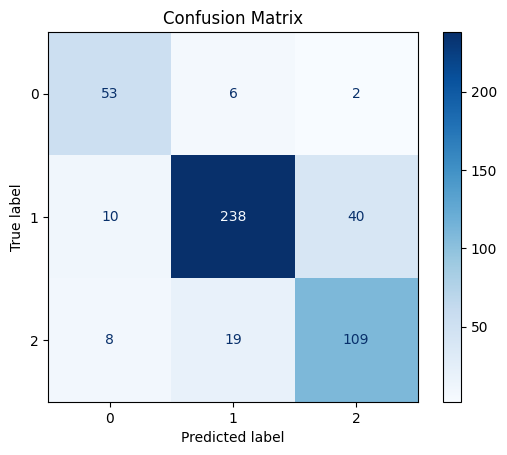

In [27]:
y_pred = trainer.predict(test_dataset)
y_pred_labels = np.argmax(y_pred.predictions, axis=1)

# Classification report
print(classification_report(y_pred.label_ids, y_pred_labels))

# Confusion matrix
cm = confusion_matrix(y_pred.label_ids, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()